In [1]:
# load data
import pandas as pd

results_file = "9-18-results.csv"
misc_file = "9-18-misc.csv"
stages_file = "9-18-stages.csv"
practice_file = "9-18-practice.csv"

results = pd.read_csv(results_file)
misc = pd.read_csv(misc_file)
stages = pd.read_csv(stages_file)
practice = pd.read_csv(practice_file)

In [2]:
# aggregation of practice data to eliminate 'duplicate' observations 
# the only race consistently having multiple practices is the Daytona500, but I think this is best practice for now
practice_agg = (
    practice.groupby(["race_id", "driver_id"])
    .agg({
        "BestLapRank" : "mean",
        "OverAllAvgRank" : "mean",
        "Con5LapRank" : "mean",
        "Con10LapRank" : "mean",
        "Con15LapRank" : "mean",
        "Con20LapRank" : "mean",
        "Con25LapRank" : "mean",
        "Con30LapRank" : "mean"
    })
)

In [3]:
# pivoting the stage dataset to eliminate 'duplicate' observations
# doing this rather than aggregation since I want to preserve stage 1 and stage 2 as seperate parts of the race (not averaged together)
stages_wide = stages.pivot_table(
    index=["race_id", "driver_id"],
    columns="stage_number",
    values=["position", "stage_points"]
)

stages_wide.columns = [
    f"stage_{col[1]}_{col[0]}" for col in stages_wide.columns.to_flat_index()
]

stages_wide = stages_wide.reset_index()

In [4]:
# data merging
df = results.copy()
df = pd.merge(df, misc, on=["race_id", "driver_id"], how="outer", suffixes=("", "_misc"))
df = pd.merge(df, stages_wide, on=["race_id", "driver_id"], how="outer")
df = pd.merge(df, practice_agg, on=["race_id", "driver_id"], how="outer")

In [5]:
# shows duplicates (same driver_id AND race_id in multiple rows)
# dupes = df[df.duplicated(subset=["race_id", "driver_id"], keep=False)]
# print(dupes.sort_values(["race_id", "driver_id"]))
# ensure no duplicates
assert df.duplicated(subset=["race_id", "driver_id"]).sum() == 0

In [6]:
# feature engineering - general classification features, improving features
# creating finish-related attributes for classification model
df["top20"] = (df["finishing_position"] <= 20).astype(int)
df["top10"] = (df["finishing_position"] <= 10).astype(int)
df["top5"] = (df["finishing_position"] <= 5).astype(int)
df["win"] = (df["finishing_position"] == 1).astype(int)
df["dnf"] = (df["finishing_status"] != "Running").astype(int)
df["crash"] = df["finishing_status"].isin(["Accident", "DVP"]).astype(int)

# stage-related attributes
df["stage_win"] = (df["stage_1_position"] == 1) | (df["stage_2_position"] == 1) | (df["stage_3_position"] == 1)
df["stage_win"] = df["stage_win"].astype(int)
df["got_stage_points"] = (df["stage_1_stage_points"] > 0) | (df["stage_2_stage_points"] > 0) | (df["stage_3_stage_points"] > 0)
df["got_stage_points"] = df["got_stage_points"].astype(int)

# changing laps_completed to percentage of total laps
df["laps_completed_pct"] = df["laps_completed"] / df["act_laps"]

# check whether driver has at least 3 starts with current team (flags new drivers or drivers switching teams)
df["has_experience_with_team"] = df.groupby(["driver_id", "team_name"]).cumcount() >= 3 
df["has_experience_with_team"] = df["has_experience_with_team"].astype(int)

In [7]:
import importlib, rolling_lagging
importlib.reload(rolling_lagging)
from rolling_lagging import lagging_rolling_features, lagging_rolling_track_type_features, lagging_rolling_track_features

lagroll_features = [
    "finishing_position", "laps_completed_pct", "laps_led", "times_led",
    "points_earned", "points_position", "stage_1_position", "stage_2_position",
    "stage_3_position", "stage_1_stage_points", "stage_2_stage_points", "stage_3_stage_points",
    "mid_ps", "closing_ps", "closing_laps_diff", "avg_ps", "passing_diff", "fast_laps",
    "top15_laps", "rating", "dnf", "crash", "top20", "top10", "top5", "win",
    "stage_win", "got_stage_points"
]

df = lagging_rolling_features(df, lagroll_features)
df = lagging_rolling_track_type_features(df, lagroll_features)
df = lagging_rolling_track_features(df, lagroll_features)

In [8]:
# commented out attributes are from Stages and Misc (already dropped due to aggregation/pivoting) but want to keep for reference
drop_cols_noise_duplicates = [
    "race_name", "car_number", "sponsor", "laps_completed", "points_delta", "disqualified", "qualifying_position",
    # "vehicle_number", "full_name", 
    "race_name_misc", "sch_laps", "start_ps", "ps", "best_ps", "worst_ps", "lead_laps", "laps", 
    # "Number", "FullName", "Manufacturer", "Sponsor", "BestLapTime", "OverAllAvg", "Con5Lap", 
    # "Con10Lap", "Con15Lap", "Con20Lap", "Con25Lap", "Con30Lap"
    ]

df = df.drop(columns=drop_cols_noise_duplicates)

In [9]:
from xgboost import XGBClassifier, XGBRegressor 
# train-test split 
import importlib, utils 
importlib.reload(utils) 
from utils import chronological_split 

target_col = "finishing_position" 

# call split function (ensures training data is always earlier than testing data)
X_train, X_test, y_train, y_test = chronological_split(df, target_col, 0.2)

In [10]:
# Classification model for categorical targets, regression model for continuous targets
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

if target_col in ["top20", "top10", "top5", "win", "dnf", "crash", "got_stage_points", "stage_win"]:
    model = XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        enable_categorical=True, scale_pos_weight=pos_weight, random_state=42
    )
    target_type = "classification"
else:
    for col in X_train.select_dtypes(include=["category", "object"]).columns:
        X_train[col] = X_train[col].astype("category")
        X_test[col] = X_test[col].astype("category")

    model = XGBRegressor(
        n_estimators=293, learning_rate=0.01714799, max_depth=4,
        subsample=0.928857, colsample_bytree=0.603768, tree_method="hist",
        enable_categorical=True, scale_pos_weight=pos_weight, random_state=42
    )
    target_type = "regression"

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.603768
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


{'RMSE': 9.87956436868104, 'MAE': 8.262571475573575, 'R2': 0.19478031667305995}


<Figure size 1200x800 with 0 Axes>

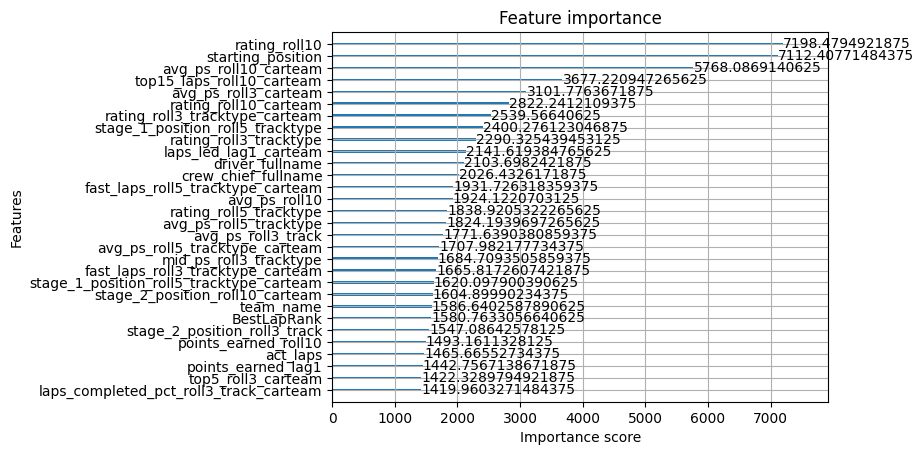

In [11]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

from utils import evaluate_classification_model
from utils import evaluate_regression_model

# Evaluation
if target_type == "regression":
    metrics = evaluate_regression_model(model, X_test, y_test)
    print(metrics)
if target_type == "classification":
    metrics = evaluate_classification_model(model, X_test, y_test)
    print(metrics)
    best_threshold = metrics["Best_threshold"]

# Feature importance plot
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=30, importance_type="gain")
plt.savefig(f"feature_importance_{target_col}.png")
plt.show()

c:\Users\joeah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


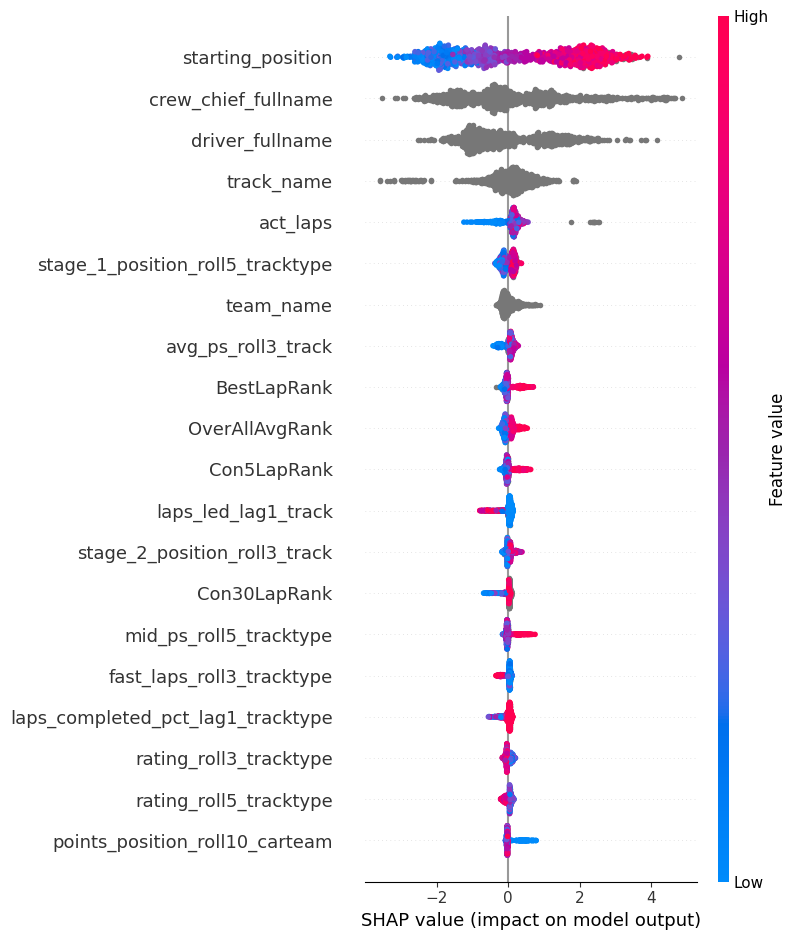

In [12]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test)

In [13]:
# --- Get feature importances ---
importances = model.feature_importances_
feature_names = X_train.columns

# Put into a DataFrame for easier filtering
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# --- Keep top 50% ---
n_keep = int(len(feat_df) * 0.4195)   # keep optimal percentage of features
top_features = feat_df.head(n_keep)["feature"].tolist()

print(f"Keeping {len(top_features)} features out of {len(feature_names)}")

# --- Reduce dataset ---
X_train_reduced = X_train[top_features]
X_test_reduced  = X_test[top_features]

Keeping 221 features out of 527


In [14]:

# import optuna
# import numpy as np
# from xgboost import XGBRegressor
# from sklearn.model_selection import cross_val_score

# # --- Step 1: Precompute feature importance ranking ---
# # You already trained one model, so reuse its feature importance
# importances = model.feature_importances_
# feature_ranking = np.argsort(importances)[::-1]  # indices sorted by importance, high -> low

# # --- Step 2: Define a helper to reduce features ---
# def reduce_features(X, keep_ratio):
#     """
#     Keep top X% features by importance.
#     """
#     n_features = int(len(feature_ranking) * keep_ratio)
#     selected_idx = feature_ranking[:n_features]
#     return X.iloc[:, selected_idx]


# # --- Step 3: Define Optuna objective ---
# def objective(trial):
#     # Suggest feature keep ratio
#     keep_ratio = trial.suggest_float("keep_ratio", 0.1, 1.0)  # between 10% and 100%
    
#     # Reduce training set
#     X_train_reduced = reduce_features(X_train, keep_ratio)
    
#     # Suggest XGBoost hyperparameters
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 200, 600),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "tree_method": "hist",
#         "enable_categorical": True,
#         "random_state": 42
#     }
    
#     # Train + cross-validate
#     model = XGBRegressor(**params)
#     score = cross_val_score(
#         model, X_train_reduced, y_train,
#         scoring="neg_root_mean_squared_error",
#         cv=3,
#         n_jobs=-1
#     ).mean()
    
#     return -score  # minimize RMSE


# # --- Step 4: Run study ---
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# print("Best trial:")
# print("  Params:", study.best_trial.params)
# print("  RMSE:", study.best_value)